In [2]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


This notebook explores the [COVID19 Government Measures Dataset](https://www.acaps.org/covid19-government-measures-dataset)

In [3]:
df = pd.read_excel("acaps_covid19_goverment_measures_dataset.xlsx", sheet_name="Database")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8294 entries, 0 to 8293
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ID                  8294 non-null   int64         
 1   COUNTRY             8294 non-null   object        
 2   ISO                 8294 non-null   object        
 3   ADMIN_LEVEL_NAME    764 non-null    object        
 4   PCODE               0 non-null      float64       
 5   REGION              8294 non-null   object        
 6   LOG_TYPE            8294 non-null   object        
 7   CATEGORY            8294 non-null   object        
 8   MEASURE             8294 non-null   object        
 9   TARGETED_POP_GROUP  8294 non-null   object        
 10  COMMENTS            8153 non-null   object        
 11  NON_COMPLIANCE      7085 non-null   object        
 12  DATE_IMPLEMENTED    8072 non-null   datetime64[ns]
 13  SOURCE              8278 non-null   object      

Remarks about the info results:
- The PCODE column is empty
- ADMIN_LEVEL_NAME and Alternative source are mostly empty
- All rows have ID, COUNTRY, ISO, REGION, LOG_TYPE, CATEGORY, MEASURE, TARGETED_POP_GROUP and ENTRY_DATE
- Not all measures have a source or link

We filter out all rows without a link or source and alternative source. We can also drop the PCODE column.

In [4]:
df = df.drop(columns=["PCODE"])

old_shape = df.shape
df = df.loc[~((df["SOURCE"].isna() | df["LINK"].isna()) & df["Alternative source"].isna())]
print(f"Dropped {old_shape[0] - df.shape[0]} rows. {df.shape[0]} rows remain.")

Dropped 33 rows. 8261 rows remain.


This paper is about measures, so lets inspect that column

In [5]:
print("There are", len(df["MEASURE"].unique()), "unique measures:\n")

print(df["MEASURE"].value_counts())

There are 39 unique measures:

Economic measures                                               1152
Strengthening the public health system                           841
Limit public gatherings                                          640
Isolation and quarantine policies                                506
Public services closure                                          452
Awareness campaigns                                              355
General recommendations                                          341
Border closure                                                   332
International flights suspension                                 314
Domestic travel restrictions                                     307
Schools closure                                                  306
Partial lockdown                                                 305
Visa restrictions                                                295
Emergency administrative structures activated or established     268
Cur

Inspection of results shows that there are less than 39 unique measures due to capitalization inconsistencies. We fix this below.

In [0]:
df["MEASURE"] = df["MEASURE"].str.lower()
measure_counts = df["MEASURE"].value_counts()

print("There are", len(df["MEASURE"].unique()), "unique measures.")

There are 35 unique measures.


With measures cleaned up, we can investigate countries.

In [6]:
country_groups = df.groupby("COUNTRY")
measures_per_country = country_groups["MEASURE"].value_counts()

print("The Netherlands implemented the following amount of measures:")
country_groups.get_group("Netherlands")[["LOG_TYPE", "MEASURE","COMMENTS"]]

The Netherlands implemented the following amount of measures:


,LOG_TYPE,MEASURE,COMMENTS
5313,Introduction / extension of measures,Isolation and quarantine policies,residents with symptoms requested to self-quar...
5314,Introduction / extension of measures,Limit public gatherings,limit of public gatherings to 100 persons unti...
5315,Introduction / extension of measures,Schools closure,closure of schools and nurseries from 15 March...
5316,Introduction / extension of measures,Public services closure,"All bars, cafes, restaurants, sports clubs, gy..."
5317,Introduction / extension of measures,General recommendations,Everyone in the Netherlands is requested to ke...
5318,Introduction / extension of measures,Economic measures,The SME credit guarantee (BMKB) scheme will be...
5319,Introduction / extension of measures,Economic measures,The Temporary Emergency Bridging Measure for ...
5320,Introduction / extension of measures,Economic measures,Self-employed professionals can apply for an e...
5321,Introduction / extension of measures,Limit public gatherings,"All gatherings are prohibited until 1 June, ev..."
5322,Introduction / extension of measures,Limit public gatherings,Gatherings of 3 or more people that do not kee...


Remarks:
- Introduction and extension measures are grouped. Measure 5337 is for example an extension of 5321. Measure 5328 is an extension of all measures before. This may have to be dealt with.
- The dataset has uncertainties, shown in measure 5332: "CHECK AGAIN CLOSER TO DATE"
- The measures are incomplete. There is no mention of the "Changes in prison-related policies" measure type, [even tough the Netherlands did introduce them on March 13](https://www.rijksoverheid.nl/actueel/nieuws/2020/03/13/dji-treft-preventieve-corona-maatregelen) and [extended them on April 2](https://www.rijksoverheid.nl/actueel/nieuws/2020/04/01/dji-verlengt-corona-maatregelen-t-m-28-april)

Incompleteness is something we cannot deal with manually due to the vast amount of countries and measures. The string "CHECK AGAIN CLOSER TO DATE" can be queried to discover how many uncertainties there are.

In [7]:
df["COMMENTS"].str.contains("CHECK AGAIN CLOSER TO DATE").value_counts()

False    8124
True        1
Name: COMMENTS, dtype: int64

This query yields only one result, so this is no worry. We can also look how many extensions are mentioned in the comments. We do this by matching on the regex pattern "(E|e)xten", which should capture all words similar to "extension", like "extended", "extensions" et cetera. We add the result as a column to our data.

In [8]:
df["IS_EXTENSION"] = df["COMMENTS"].str.contains(r"(E|e)xten")
df["IS_EXTENSION"].value_counts()

/home/zwieteri/.local/lib/python3.8/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


False    7517
True      608
Name: IS_EXTENSION, dtype: int64

Using this data, we can learn more about the measures. The below timeline shows when the Netherlands introduced measures (yellow), and when they extended measures (green) and when they phased out measures (purple).

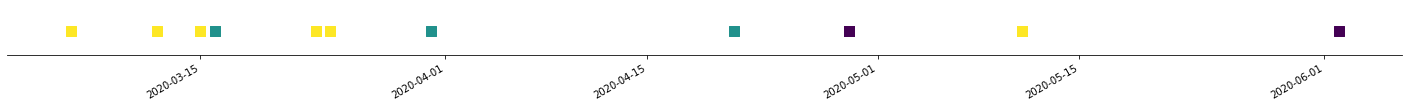

In [9]:
def calculate_types(group):
  row_count = group.shape[0]
  measure_type = []
  for i in range(row_count):
    if group["LOG_TYPE"].iloc[i] == "Phase-out measure":
      val = 0
    else:
      if group["IS_EXTENSION"].iloc[i]:
        val = 1
      else:
        val = 2
    measure_type.append(val)
  return measure_type

def show_timeline(group):
  row_count = group.shape[0]
  measure_type = calculate_types(group)

  fig, ax = plt.subplots(figsize=(row_count,1))
  ax.scatter(group["DATE_IMPLEMENTED"], [1]*len(group["DATE_IMPLEMENTED"]), c=measure_type, marker='s', s=100)
  fig.autofmt_xdate()
  ax.yaxis.set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.xaxis.set_ticks_position('bottom')
  plt.show()

nl_group = country_groups.get_group("Netherlands")
show_timeline(nl_group)